# Learning to stabilize a linear system

For this example we demonstrate learning to stabilize a double integrator system using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="https://github.com/pnnl/neuromancer/blob/master/examples/control/figs/DPC_simple_method.png?raw=1" width="600">  

- https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/control/Part_1_stabilize_linear_system.ipynb

In [ ]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

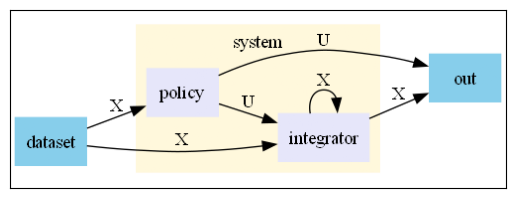

In [ ]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

# closed loop system definition
cl_system = System([policy, double_integrator])
cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the system operates in. 

In [ ]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [ ]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.0001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [ ]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

C:\Users\usr\miniconda3\envs\neuromancer\lib\site-packages\neuromancer\constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
C:\Users\usr\miniconda3\envs\neuromancer\lib\site-packages\neuromancer\constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 203.424560546875
epoch: 1  train_loss: 202.97561645507812
epoch: 2  train_loss: 202.5296173095703
epoch: 3  train_loss: 202.08290100097656
epoch: 4  train_loss: 201.65713500976562
epoch: 5  train_loss: 201.25128173828125
epoch: 6  train_loss: 200.844482421875
epoch: 7  train_loss: 200.42604064941406
epoch: 8  train_loss: 199.99343872070312
epoch: 9  train_loss: 199.5414581298828
epoch: 10  train_loss: 199.06784057617188
epoch: 11  train_loss: 198.56805419921875
epoch: 12  train_loss: 198.0380401611328
epoch: 13  train_loss: 197.47579956054688
epoch: 14  train_loss: 196.87667846679688
epoch: 15  train_loss: 196.23739624023438
epoch: 16  train_loss: 195.55502319335938
epoch: 17  train_loss: 194.8282470703125
epoch: 18  train_loss: 194.06080627441406
epoch: 19  train_loss: 193.2508544921875
epoch: 20  train_loss: 192.39625549316406
epoch: 21  train_loss: 191.4949188232422
epoch: 22  train_loss: 190.53968811035156
epoch: 23  train_loss: 189.52859497070312
epoch: 24  t

# Evaluate best model on a system rollout 


In [ ]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)

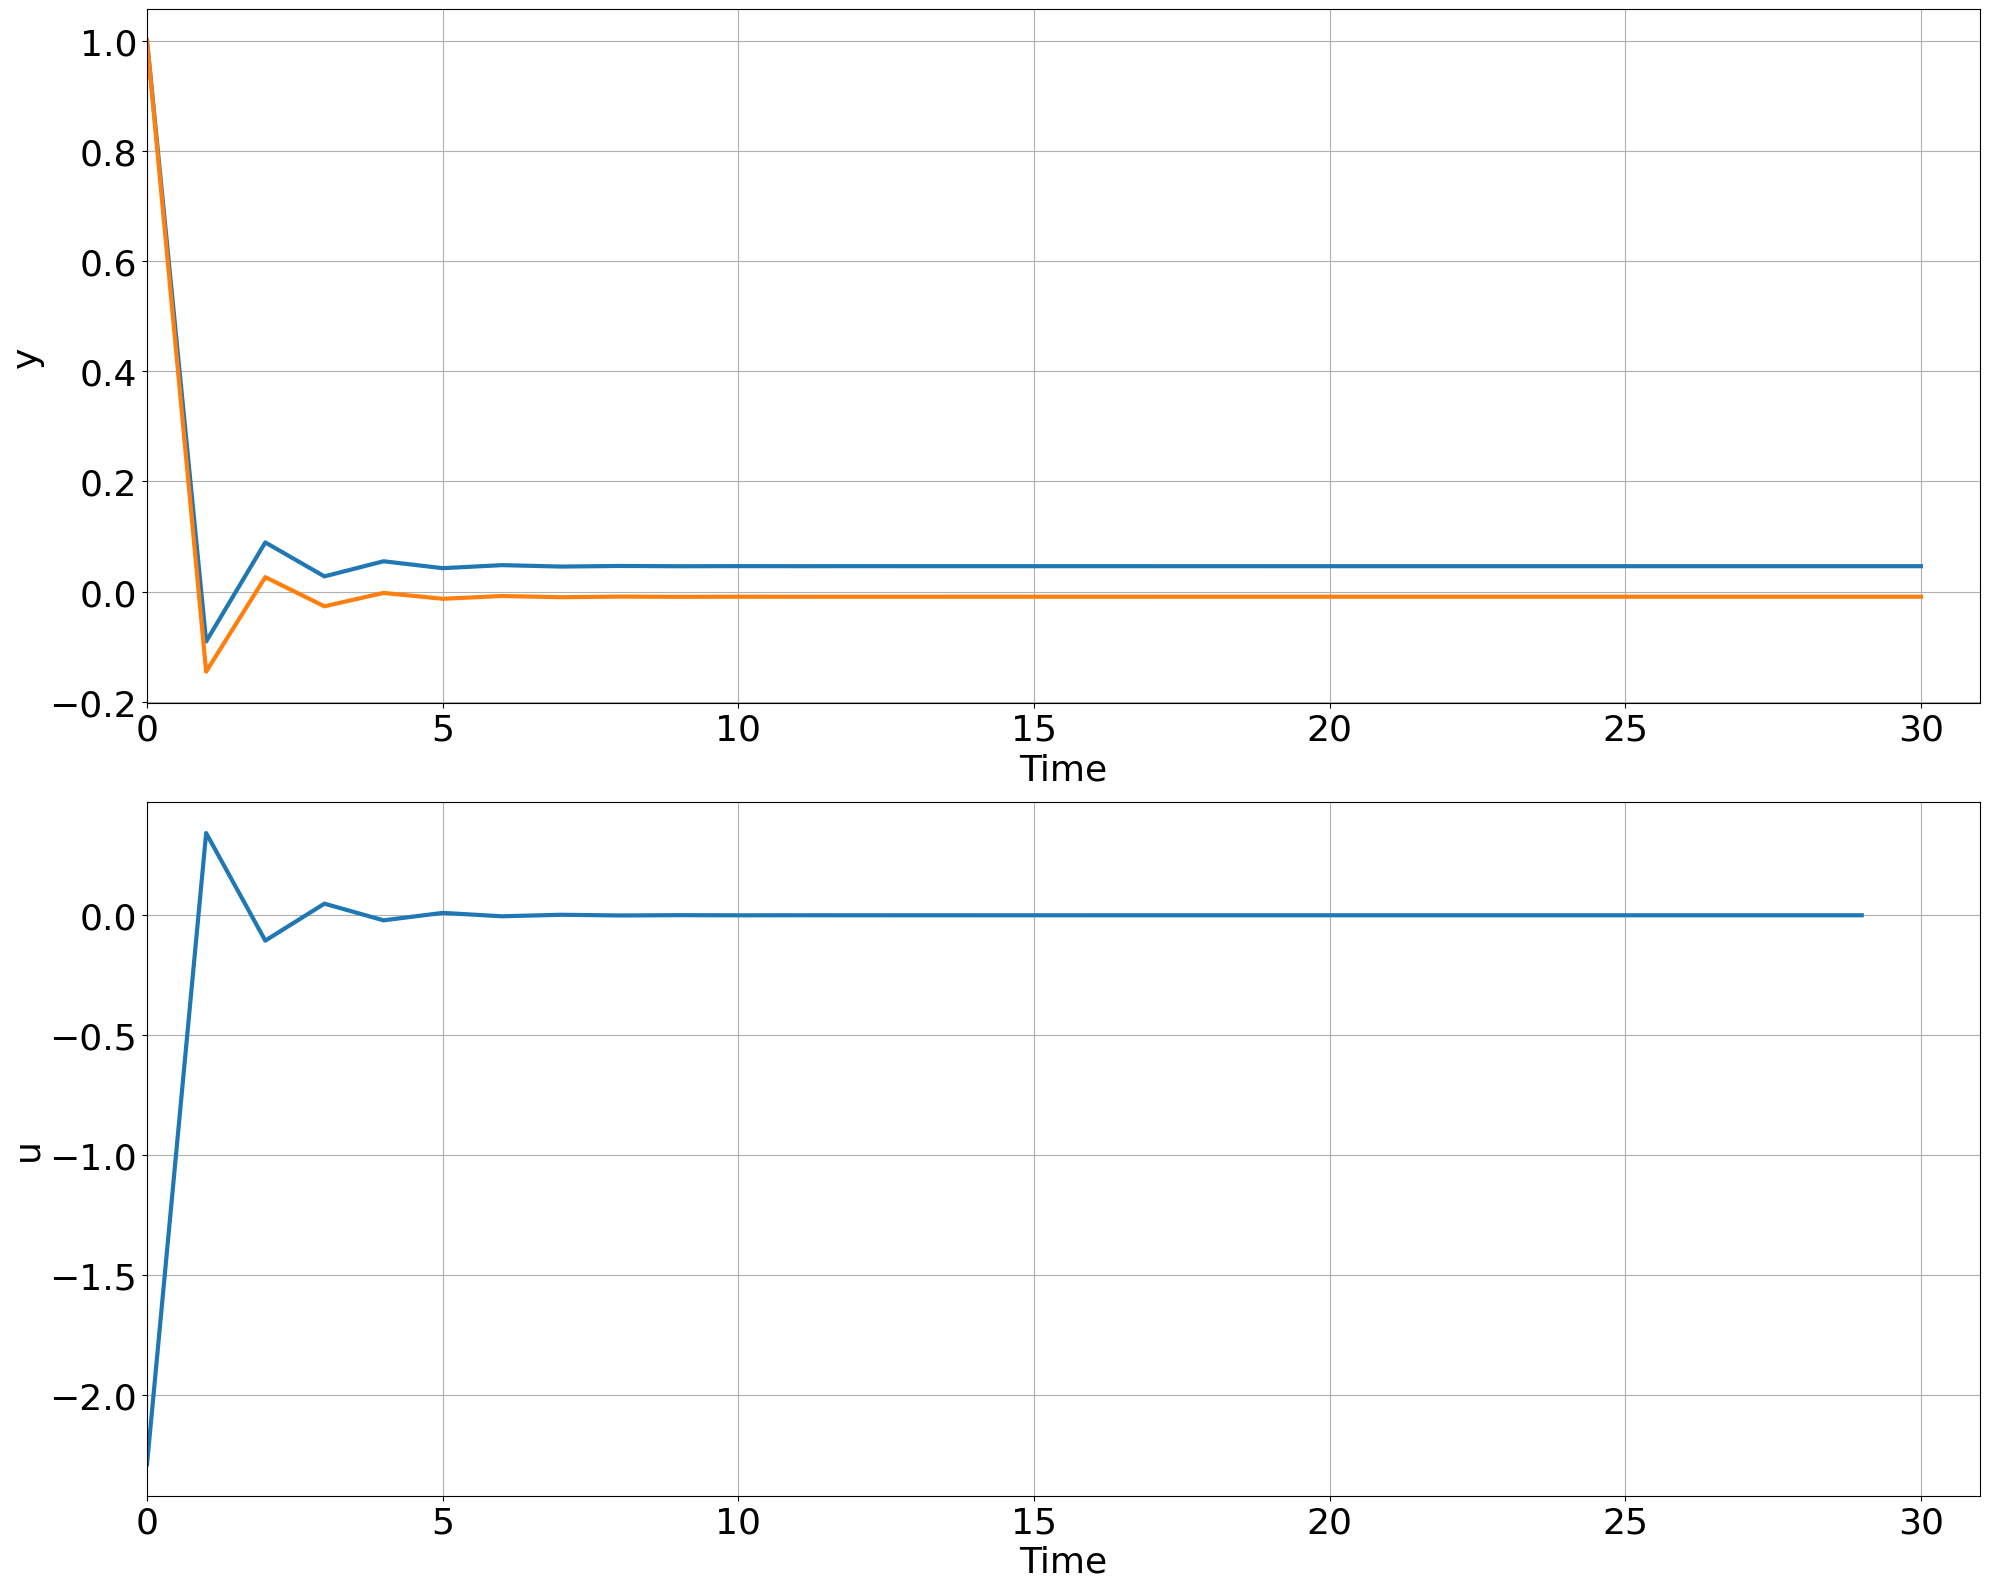

In [ ]:
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png');

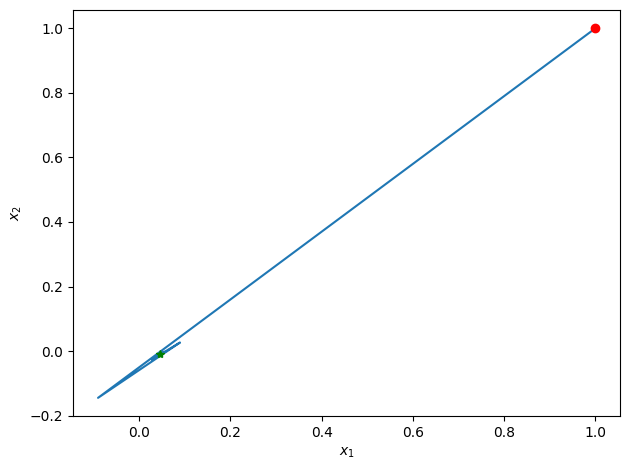

<Figure size 640x480 with 0 Axes>

In [ ]:
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png');